# New Environment: Creating and Modeling
<!-- 
<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/notebooks/1-quickstart.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

[**Documentation**](https://rl4co.readthedocs.io/) |  [**Getting Started**](https://github.com/ai4co/rl4co/tree/main#getting-started) | [**Usage**](https://github.com/ai4co/rl4co/tree/main#usage) | [**Contributing**](#contributing) | [**Paper**](https://arxiv.org/abs/2306.17100) | [**Citation**](#cite-us) -->

In this notebook, we will show how to extend RL4CO to solve new problems from zero to hero! 🚀

<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/notebooks/tutorials/2-solving-new-problem.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

### Contents

1. [Environment](#environment-creation)
2. [Modeling](#modeling)
3. [Training](#training-our-model)
4. [Evaluation](#evaluation)


### Problem: MDPDP
Let us consider a new complex problem: the _Open Multi-Depot Pickup and Delivery Problem (MDPDP)_. 
- **Objective**: find set of routes for a fleet of vehicles to pickup and deliver a set of orders such that the total routes are minimized. Vehicles start from different depots and the problem is _open_ since they do not need to return to the depot.
- **Constraints**:
    - Maximum number of vehicles (i.e. agents) is fixed
    - Each vehicle has a maximum capacity
    - Pickup and delivery pairs have to be served by the same vehicle with a precendence constraint (no pickup before delivery)

The MDPDP is a complex, realistic problem that can be solved with RL4CO. For instance, this problem can be found in the context of ride-sharing, where a fleet of vehicles (e.g. taxis) have to pickup and deliver passengers to their destinations or in the context of food delivery, where a fleet of vehicles (e.g. riders) have to pickup and deliver orders to customers.

### Installation

In [1]:
## Uncomment the following line to install the package from PyPI
## You may need to restart the runtime in Colab after this
## Remember to choose a GPU runtime for faster training!

# !pip install rl4co

### Imports

In [2]:


%load_ext autoreload
%autoreload 2

import sys; sys.path.append(2*"../")

from typing import Optional
from einops import rearrange
from matplotlib.axes import Axes

import torch
import torch.nn as nn

from tensordict.tensordict import TensorDict
from torchrl.data import (
    BoundedTensorSpec,
    CompositeSpec,
    UnboundedContinuousTensorSpec,
    UnboundedDiscreteTensorSpec,
)

from rl4co.envs.common.base import RL4COEnvBase
from rl4co.utils.ops import gather_by_index, get_tour_length
from rl4co.models.nn.utils import rollout, random_policy
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy
from rl4co.utils.trainer import RL4COTrainer

2023-08-17 10:54:24.930233: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-17 10:54:24.950591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 10:54:25.406396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Environment Creation

We will base environment creation on the `RL4COEnvBase` class, which is based on [TorchRL](https://github.com/pytorch/rl):

In [3]:
?? RL4COEnvBase

Init signature:
 RL4COEnvBase(
    *,
    data_dir: str = 'data/',
    train_file: str = None,
    val_file: str = None,
    test_file: str = None,
    check_solution: bool = True,
    seed: int = None,
    device: str = 'cpu',
    **kwargs,
)
Source:        
class RL4COEnvBase(EnvBase):
    """Base class for RL4CO environments based on TorchRL EnvBase

    Args:
        data_dir: Root directory for the dataset
        train_file: Name of the training file
        val_file: Name of the validation file
        test_file: Name of the test file
        check_solution: Whether to check the validity of the solution at the end of the episode
        seed: Seed for the environment
        device: Device to use. Generally, no need to set as tensors are updated on the fly
    """

    batch_locked = False

    def __init__(
        self,
        *,
        data_dir: str = "data/",
        train_file: str = None,
        val_file: str = None,
        test_file: str = None,
        check_solution

### Reset

The `_reset` function is used to initialize the environment to an initial state. It returns a TensorDict of the initial state.

In [4]:
def _reset(
    self, td: Optional[TensorDict] = None, batch_size: Optional[int] = None
) -> TensorDict:
    if batch_size is None:
        batch_size = self.batch_size if td is None else td.batch_size
    
    # Data generation: if not provided, generate a new batch of data
    if td is None or td.is_empty():
        td = self.generate_data(batch_size=batch_size)

    self.device = td.device

    td_reset = TensorDict(
        {
            "pickup_locs": td["pickup_locs"],
            "delivery_locs": td["delivery_locs"],
            "vehicle_locs": td["vehicle_locs"],
            "pickup_visited": torch.zeros(
                *td["pickup_locs"].shape[:-1], dtype=torch.bool, device=td.device
            ),
            "delivery_visited": torch.zeros(
                *td["delivery_locs"].shape[:-1], dtype=torch.bool, device=td.device
            ),
            "to_deliver": torch.zeros(
                *td["delivery_locs"].shape[:-1], dtype=torch.bool, device=td.device
            ),  # whether the delivery is to be delivered (i.e., the corresponding pickup is visited)
            "i": torch.zeros(batch_size, dtype=torch.int64, device=td.device),
            "current_vehicle_idx": torch.zeros(
                *batch_size, dtype=torch.long, device=td.device
            ),  # used to denote vehicle index
            "current_vehicle_loads": torch.zeros(
                *batch_size, dtype=torch.int64, device=td.device
            ),  # used to denote current vehicle loads
            "current_vehicle_max_loads": torch.zeros(
                *batch_size, dtype=torch.int64, device=td.device
            ),  # used to denote the maximal vehicle loads from the beginning
            "current_vehicle_pickup_visited": torch.zeros(
                *td["pickup_locs"].shape[:-1], 1, dtype=torch.bool, device=td.device
            ),  # used to denote whether the pickup is visited by the current vehicle
        },
        batch_size=batch_size,
    )

    # Compute action mask: mask out actions that are not allowed (e.g., pickup before delivery)
    td_reset.set("action_mask", self.get_action_mask(td_reset))
    return td_reset    

### Step

Environment `_step`: this defines the state update of the TSP problem gived a TensorDict (td in the code) of the current state and the action to take:

In [5]:
def _step(self, td: TensorDict) -> TensorDict:
    # action: [batch_size, (pickups | deliveries | vehicles)]
    selected = td["action"]

    # The number of orders is set based on the number of vehicles and the capacity
    num_orders = self.num_vehicles * self.capacity

    # Identify the action type
    is_pickup = selected < num_orders  # bool mask -- [batch]
    is_delivery = (selected >= num_orders) & (selected < num_orders * 2)
    is_vehicle = selected >= num_orders * 2

    selected_pickups = selected[is_pickup] 
    selected_deliveries = selected[is_delivery] - num_orders

    # ====  Pickup status update ====
    td["pickup_visited"][is_pickup, selected_pickups] = True

    # Update current load
    td["current_vehicle_loads"][is_pickup] += 1

    # Update history of pickup visited by the current vehicle
    td["current_vehicle_max_loads"][is_pickup] += 1
    td["current_vehicle_max_loads"][is_pickup].clamp_(max=self.capacity)

    # Set the paired deliveries' 'to_delivery' as True
    td["to_deliver"][is_pickup, selected_pickups] = True

    # Dropoff the load
    td["delivery_visited"][is_delivery, selected_deliveries] = True
    td["current_vehicle_loads"][is_delivery] -= 1

    # ====  Vehicle status update ====
    # Increment vehicle idx counter
    if td["i"][0] > 0:
        td["current_vehicle_idx"][is_vehicle] += 1
        td["current_vehicle_idx"][is_vehicle].clamp_(max=self.num_vehicles)
    # Initialize vehicle load and max loads
    td["current_vehicle_loads"][is_vehicle] = 0
    td["current_vehicle_max_loads"][is_vehicle] = 0

    done = td["pickup_visited"].all(dim=-1) & td["delivery_visited"].all(dim=-1)
    # The reward is calculated outside via get_reward for efficiency, so we set it to -inf here
    reward = torch.ones_like(done) * float("-inf")

    # Reti
    td_step = TensorDict(
        {
            "next": {
                "pickup_locs": td["pickup_locs"],
                "delivery_locs": td["delivery_locs"],
                "vehicle_locs": td["vehicle_locs"],
                "pickup_visited": td["pickup_visited"],
                "delivery_visited": td["delivery_visited"],
                "to_deliver": td["to_deliver"],
                "i": td["i"] + 1,
                "current_vehicle_idx": td["current_vehicle_idx"],
                "current_vehicle_loads": td["current_vehicle_loads"],
                "current_vehicle_max_loads": td["current_vehicle_max_loads"],
                "current_vehicle_pickup_visited": td[
                    "current_vehicle_pickup_visited"
                ],
                "current_node": selected,
                "done": done,
                "reward": reward,
            },
        },
        td.shape,
    )
    td_step["next"].set("action_mask", self.get_action_mask(td_step["next"]))
    return td_step

### Action Mask

The `get_action_mask` function ensured that we only selected actions that were valid for the current state. This is important because we don't want to select actions that are invalid - such as, we cannot deliver a package if we don't have one or visit a location that we have already visited.

In [6]:
def get_action_mask(self, td: TensorDict) -> torch.Tensor:
    # At the first decoding step, policy is allowed to select the first vehicle only.
    if td["i"][0] == 0:

        total_nodes = self.num_vehicles * self.capacity * 2 + self.num_vehicles

        action_mask = torch.zeros(
            *td.batch_size,
            total_nodes,
            dtype=torch.bool,
            device=td.device,
        )
        action_mask[:, self.num_vehicles * self.capacity * 2] = True
        return action_mask

    # Handling pickup action mask
    pickup_action_mask = ~td["pickup_visited"]
    pickup_action_mask[td["current_vehicle_max_loads"] == self.capacity] = False

    # If current vehicle carries "capacity" loads, it can only deliver
    pickup_action_mask[td["current_vehicle_loads"] >= self.capacity] = False

    # Handling delivery action mask
    delivery_action_mask = td["to_deliver"] & ~td["delivery_visited"]

    # Handling vehicle action mask
    # vehicle can be selected only if all scheduled deliveries are delivered
    # selecting vehicle indicates the end of the current vehicle's tour
    pd_action_mask = torch.cat([pickup_action_mask, delivery_action_mask], dim=-1)

    # Vehicle action mask becomes true only when the current vehicle finished all orders (i.e., the pairs of pickup and delivery)
    # here the next vehicle will be selected!
    vehicle_action_mask = (
        torch.nn.functional.one_hot(
            (td["current_vehicle_idx"] + 1).clamp(max=self.num_vehicles - 1),
            num_classes=self.num_vehicles,
        )
        .bool()
    )

    # "Terminate" action is allowed if
    # (1) the current vehicle is not able to visit any pickup, and
    # (2) the scheduled deliveries are all delivered
    vehicle_action_mask[pd_action_mask.sum(dim=-1) > 0] = False

    # Action mask is true when the action is allowed (i.e. feasible)
    action_mask = torch.cat([pd_action_mask, vehicle_action_mask], dim=-1)
    return action_mask


### Reward function

The `get_reward` function is used to evaluate the reward given the solution (actions).

In [7]:
def get_reward(self, td: TensorDict, actions: torch.Tensor) -> torch.Tensor:
    locs = torch.cat(
        [td["pickup_locs"], td["delivery_locs"], td["vehicle_locs"]], dim=-2
    )
    ordered_locs = gather_by_index(locs, actions)

    if ordered_locs.dim() == 2:  # batch size = 1
        ordered_locs = ordered_locs[None, ...]

    # Reorder the tours in two dimensions
    ordered_locs = rearrange(
        ordered_locs,
        "... (n c) two -> ... n c two",
        n=self.num_vehicles,  # number of vehicles
        c=self.capacity * 2 + 1,
        two=2,
    )  # batch, num vehicles, capacity, 2

    dists = (ordered_locs[..., :-1, :] - ordered_locs[..., 1:, :]).norm(p=2, dim=-1) 
    dists = dists.sum(dim=(-1, -2))  # [batch]
    return -dists # negative distance is the reward

### Environment Action Specs

This defines the input and output domains of the environment - similar to Gym's `spaces`. 
This is not strictly necessary, but it is useful to have a clear definition of the environment's action and observation spaces and if we want to sample actions using TorchRL's utils

In [8]:
def _make_spec(self, td_params: TensorDict = None):
    self.observation_spec = CompositeSpec(
        delivery_locs=BoundedTensorSpec(
            minimum=self.min_loc,
            maximum=self.max_loc,
            shape=(self.num_vehicles * self.capacity, 2),
        ),
        pickup_locs=BoundedTensorSpec(
            minimum=self.min_loc,
            maximum=self.max_loc,
            shape=(self.num_vehicles * self.capacity, 2),
        ),
        vehicle_locs=BoundedTensorSpec(
            minimum=self.min_loc,
            maximum=self.max_loc,
            shape=(self.num_vehicles, 2),
        ),
        pickup_visited=UnboundedDiscreteTensorSpec(
            shape=(self.num_vehicles * self.capacity), dtype=torch.int64
        ),
        delivery_visited=UnboundedDiscreteTensorSpec(
            shape=(self.num_vehicles * self.capacity), dtype=torch.int64
        ),
        to_deliver=UnboundedDiscreteTensorSpec(
            shape=(self.num_vehicles * self.capacity), dtype=torch.int64
        ),
        current_vehicle_id=UnboundedDiscreteTensorSpec(shape=(1), dtype=torch.int64),
        current_vehicle_loads=UnboundedDiscreteTensorSpec(
            shape=(1), dtype=torch.int64
        ),
        current_vehicle_max_loads=UnboundedDiscreteTensorSpec(
            shape=(1), dtype=torch.int64
        ),
        current_vehicle_pickup_visited=UnboundedDiscreteTensorSpec(
            shape=(self.num_vehicles * self.capacity), dtype=torch.int64
        ),
    )

    self.input_spec = self.observation_spec.clone()
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        minimum=0,
        maximum=self.num_vehicles + self.num_vehicles * self.capacity * 2,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(1,))
    self.done_spec = UnboundedDiscreteTensorSpec(shape=(1,), dtype=torch.bool)

### Data generation

This function allows for generating data for training instances if no data is provided.

In [9]:
def generate_data(self, batch_size) -> TensorDict:
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size

    # Generate random locations
    pickup_locs = (
        torch.FloatTensor(*batch_size, self.num_vehicles * self.capacity, 2)
        .uniform_(self.min_loc, self.max_loc)
        .to(self.device)
    )
    
    # Here we generate pickup and delivery locations not far apart from each other
    rs = (
        torch.FloatTensor(*batch_size, self.num_vehicles * self.capacity)
        .uniform_(0.0, 0.2)
        .to(self.device)
    )
    thetas = (
        torch.FloatTensor(*batch_size, self.num_vehicles * self.capacity)
        .uniform_(0.0, 360.0)
        .to(self.device)
    )

    delta_x = rs * torch.cos(thetas)
    delta_y = rs * torch.sin(thetas)

    delivery_locs = pickup_locs.clone() + torch.stack([delta_x, delta_y], dim=-1)

    vehicle_locs = (
        torch.FloatTensor(*batch_size, self.num_vehicles, 2)
        .uniform_(self.min_loc, self.max_loc)
        .to(self.device)
    )

    return TensorDict(
        {
            "pickup_locs": pickup_locs,
            "delivery_locs": delivery_locs,
            "vehicle_locs": vehicle_locs,
            "first_node": torch.zeros(
                *batch_size, dtype=torch.int64, device=self.device
            ),
        },
        batch_size=batch_size,
    )

### Render function

The `render` function is optional, but can be useful for quickly visualizing the results of your algorithm!

In [10]:
def render(
    self,
    td: TensorDict,
    actions: torch.Tensor = None,
    ax: Axes = None,
    batch_idx: int = None,
):
    import matplotlib.pyplot as plt

    def draw_line(src, dst, ax):
        ax.plot([src[0], dst[0]], [src[1], dst[1]], ls="--", c="gray")

    td = td.detach().cpu()

    if actions is None:
        actions = td.get("action", None)

    if td.batch_size != torch.Size([]):
        batch_idx = 0 if batch_idx is None else batch_idx
        td = td[0]
        actions = actions[0]

    pickup_locs = td["pickup_locs"]
    delivery_locs = td["delivery_locs"]
    vehicle_locs = td["vehicle_locs"]

    if ax is None:
        # Create a plot of the nodes
        _, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.axis("equal"); ax.grid(True)

    ax.scatter(pickup_locs[:, 0], pickup_locs[:, 1], marker="x", color="gray")
    ax.scatter(delivery_locs[:, 0], delivery_locs[:, 1], marker="^", color="gray")

    for v_i, (v_x, v_y) in enumerate(zip(vehicle_locs[:, 0], vehicle_locs[:, 1])):
        ax.scatter(v_x, v_y, color=f"C{v_i}")

    for p_loc, d_loc in zip(pickup_locs, delivery_locs):
        draw_line(p_loc, d_loc, ax)

    if actions is not None:  # draw solution if available.
        sub_tours = actions.reshape(self.num_vehicles, -1)
        loc = torch.cat([pickup_locs, delivery_locs, vehicle_locs], dim=0)
        for v_i, sub_tour in enumerate(sub_tours):
            ax.plot(loc[sub_tour][:, 0], loc[sub_tour][:, 1], color=f"C{v_i}")

### Putting everything together

In [11]:
class MDPDPEnv(RL4COEnvBase):
    """Multi-Depot Pickup and Delivery Problem (MDPDP) environment
    We consider the number of delivery locations to be num_vehicles * capacity,
    with one corresponding pickup location for each delivery location.
    The total number of locations will be:
        - num_vehicles + (2 * num_vehicles * capacity)
    """

    name = "MDPDP"

    def __init__(
        self,
        num_vehicles: int = 5,
        capacity: int = 3,
        min_loc: float = 0.0,
        max_loc: float = 1.0,
        td_params: TensorDict = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.num_vehicles = num_vehicles
        self.capacity = capacity
        self.min_loc = min_loc
        self.max_loc = max_loc
        self._make_spec(td_params)
        
    _reset = _reset
    _step = _step
    get_reward = get_reward
    get_action_mask = get_action_mask
    _make_spec = _make_spec
    generate_data = generate_data
    render = render


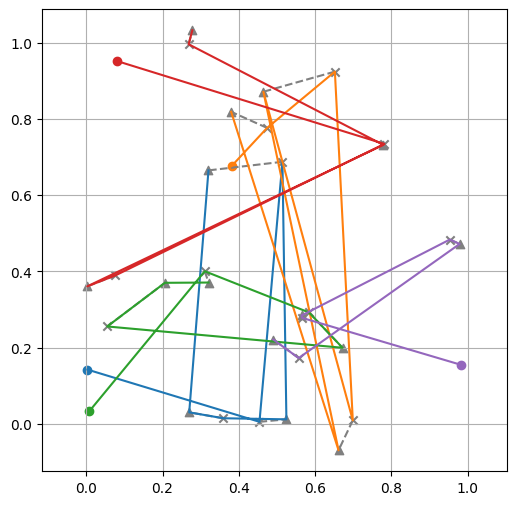

In [12]:
batch_size = 2

env = MDPDPEnv(num_vehicles=5, capacity=3)
reward, td, actions = rollout(env, env.reset(batch_size=[batch_size]), random_policy)
env.render(td, actions)

## Modeling

Now we need to model the problem by transforming input information into the latent space to be processed. In RL4CO, we divide embeddings in 3 parts:

- `init_embedding`: embed initial states of the problem
- `context_embedding`: embed context information of the problem for the current partial solution to modify the query 
- `dynamic_embedding`: embed dynamic information of the problem for the current partial solution to modify the query, key, and value (i.e. if other nodes also change state)

### Init Embedding

Embed initial problem into latent space. In our case, we project the vehicle, pickup, and delivery locations

In [13]:
class MDPDPInitEmbedding(nn.Module):
    def __init__(self, embedding_dim: int):
        super().__init__()
        node_dim = 2  # x, y
        self.init_embed_pick = nn.Linear(node_dim * 2, embedding_dim)
        self.init_embed_delivery = nn.Linear(node_dim, embedding_dim)
        self.init_embed_vehicle = nn.Linear(2, embedding_dim)

    def forward(self, td: TensorDict):
        pickup_emb = self.init_embed_pick(
            torch.cat([td["pickup_locs"], td["delivery_locs"]], dim=-1)
        )
        delivery_emb = self.init_embed_delivery(td["delivery_locs"])
        vehicle_emb = self.init_embed_vehicle(td["vehicle_locs"])
        return torch.cat([pickup_emb, delivery_emb, vehicle_emb], dim=-2)

### Context Embedding

Context embedding takes current context and returns a vector representation of it. In the MDPDP, the context is equivalent to the current node embedding

In [14]:
class MDPDPContextEmbedding(nn.Module):
    def __init__(self, embedding_dim, step_context_dim=None, linear_bias=False):
        super(MDPDPContextEmbedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.W_placeholder = nn.Parameter(torch.Tensor(self.embedding_dim).uniform_(-1, 1))
        self.project_context = nn.Linear(
            embedding_dim, embedding_dim, bias=linear_bias
        )
        
    def _cur_node_embedding(self, embeddings, td):
        if td["i"][0].item() == 0:
            batch_size = embeddings.size(0)
            context_embedding = self.W_placeholder[None, :].expand(
                batch_size, self.W_placeholder.size(-1)
            )
            return context_embedding

        cur_node_embedding = gather_by_index(embeddings, td["current_node"])
        return cur_node_embedding

    def forward(self, embeddings, td):
        cur_node_embedding = self._cur_node_embedding(embeddings, td).squeeze()
        return self.project_context(cur_node_embedding)

### Dynamic Embedding

Since the states do not change except for visited nodes, we do not need to modify the keys and values. Therefore, we set this to 0

In [15]:
class StaticEmbedding(nn.Module):
    def __init__(self, *args, **kwargs):
        super(StaticEmbedding, self).__init__()

    def forward(self, td):
        return 0, 0, 0

## Training our Model

In [16]:
# Instantiate our environment
env = MDPDPEnv(num_vehicles=5, capacity=3)

# Instantiate policy with the embeddings we created above
emb_dim = 128
policy = AutoregressivePolicy(env,
                              embedding_dim=emb_dim,
                              init_embedding=MDPDPInitEmbedding(emb_dim),
                              context_embedding=MDPDPContextEmbedding(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)


# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env, 
                       policy=policy,
                       baseline='rollout',
                       train_data_size=100_000,
                       val_data_size=10_000) 

/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
  rank_zero_warn(
/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
  rank_zero_warn(


### Rollout untrained model 

Tour lengths: ['7.96', '7.60', '10.26']


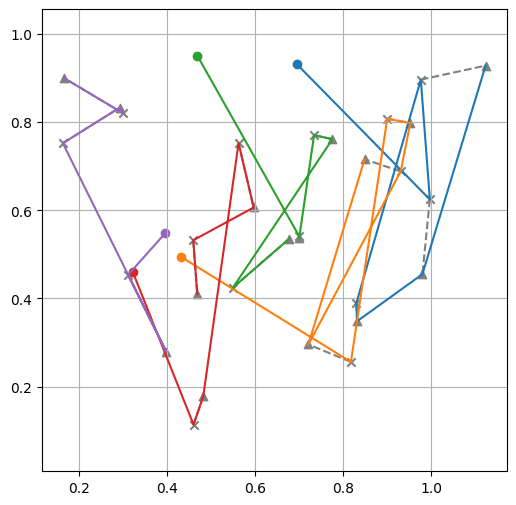

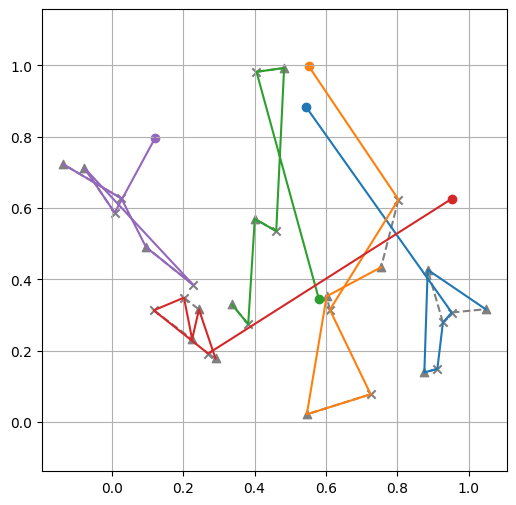

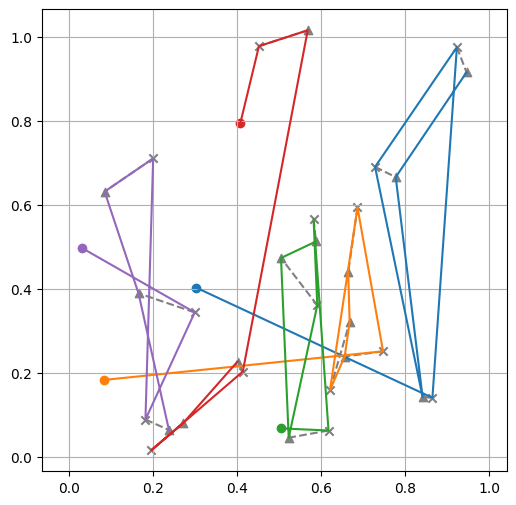

In [17]:
# Greedy rollouts over untrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

### Training loop

In [18]:
# We use our own wrapper around Lightning's `Trainer` to make it easier to use
trainer = RL4COTrainer(max_epochs=3)
trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | MDPDPEnv             | 0     
1 | policy   | AutoregressivePolicy | 694 K 
2 | baseline | WarmupBaseline       | 694 K 
--------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.557     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


## Evaluation

Tour lengths: ['4.82', '5.53', '5.22']


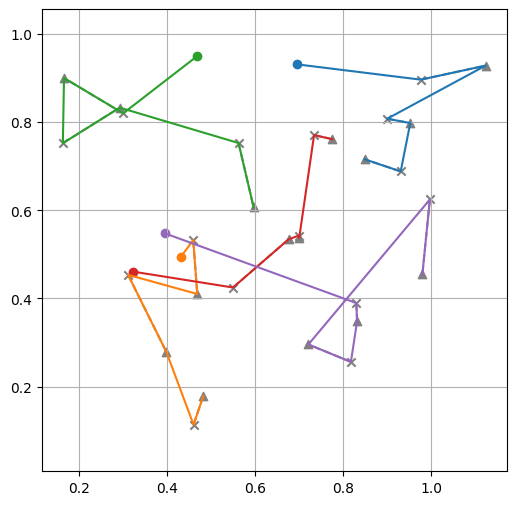

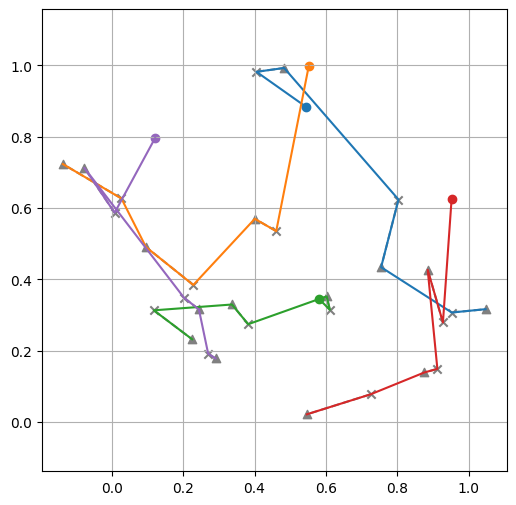

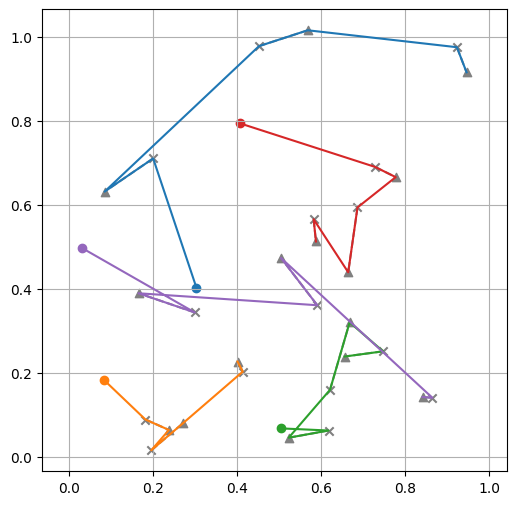

In [19]:
# Greedy rollouts over trained model (same states as previous plot)
model = model.to(device)
out = model(td_init, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)

We can see that solutions are way better than with the untrained model, even just after 3 epochs! 🚀